# Import Library

In [1]:
import csv
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pickle
import re
from nltk.tokenize import WordPunctTokenizer
import itertools
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Define Global Variables

In [2]:
NUM_WORDS = 30000
EMBEDDING_DIM = 16
MAXLEN = 50
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAIN_FILE = "./dataset/raw/train.csv"
TEST_FILE = "./dataset/raw/test.csv"
PROCESSED_TRAIN_FILE = "./dataset/processed_train_2.csv"
PROCESSED_TEST_FILE = "./dataset/processed_test_2.csv"
STOPWORDS_FILE = "./dataset/stopwordbahasa.csv"
STOPWORDS = []

# Preprocessing

In [3]:
EXTERNAL_DATA_PATH = './dataset/external'

In [4]:
# Translate emoticon
emoticon_data_path = '{}/emoticon.txt'.format(EXTERNAL_DATA_PATH)
emoticon_df = pd.read_csv(emoticon_data_path, sep='\t', header=None)
emoticon_dict = dict(zip(emoticon_df[0], emoticon_df[1]))

def translate_emoticon(t):
    for w, v in emoticon_dict.items():
        pattern = re.compile(re.escape(w))
        match = re.search(pattern,t)
        if match:
            t = re.sub(pattern,v,t)
    return t

In [5]:
sample_text = 'seru deh acaranya :-)'

print('Before :', sample_text)
print('After  :', translate_emoticon(sample_text))

Before : seru deh acaranya :-)
After  : seru deh acaranya Bahagia


In [6]:
def remove_newline(text):
    text = re.sub(r'\\n', ' ',text)
    return re.sub(r'\n', ' ',text)

In [7]:
sample_text = 'hari ini\nhari\nsabtu'

print('Before :', sample_text)
print('After  :', remove_newline(sample_text))

Before : hari ini
hari
sabtu
After  : hari ini hari sabtu


In [8]:
def remove_kaskus_formatting(text):
    text = re.sub('\[', ' [', text)
    text = re.sub('\]', '] ', text)
    text = re.sub('\[quote[^ ]*\].*?\[\/quote\]', ' ', text)
    text = re.sub('\[[^ ]*\]', ' ', text)
    text = re.sub('&quot;', ' ', text)
    text = text.strip()
    return text

In [9]:
sample_text = '[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e]yoiii cuy halo halo bandung[/QUOTE]'

print('Before :', sample_text)
print('After  :', remove_kaskus_formatting(sample_text))

Before : [QUOTE=jessepinkman16;5a50ac34d89b093f368b456e]yoiii cuy halo halo bandung[/QUOTE]
After  : yoiii cuy halo halo bandung


In [10]:
def remove_url(text):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', text)

In [11]:
sample_text = 'kemaren kacao bet de www.instagram.com/lele/lili'

print('Before :', sample_text)
print('After  :', remove_url(sample_text))

Before : kemaren kacao bet de www.instagram.com/lele/lili
After  : kemaren kacao bet de 


In [12]:
def remove_excessive_whitespace(text):
    return re.sub('  +', ' ', text)

In [13]:
sample_text = 'budi      pergi ke           pasar'

print('Before :', sample_text)
print('After  :', remove_excessive_whitespace(sample_text))

Before : budi      pergi ke           pasar
After  : budi pergi ke pasar


In [14]:
def tokenize_text(text, punct=False):
    text = WordPunctTokenizer().tokenize(text)
    text = [word for word in text if punct or word.isalnum()]
    text = ' '.join(text)
    text = text.strip()
    return text

In [15]:
sample_text = 'kemarin,aku pergi ke dagas.terus ketemu sama Ilham.'

print('Before :', sample_text)
print('After  :', tokenize_text(sample_text))

Before : kemarin,aku pergi ke dagas.terus ketemu sama Ilham.
After  : kemarin aku pergi ke dagas terus ketemu sama Ilham


In [16]:
slang_words = pd.read_csv('{}/slangword.csv'.format(EXTERNAL_DATA_PATH))
slang_dict = dict(zip(slang_words['original'],slang_words['translated']))

def transform_slang_words(text):
    word_list = text.split()
    word_list_len = len(word_list)
    transformed_word_list = []
    i = 0
    while i < word_list_len:
        if (i + 1) < word_list_len:
            two_words = ' '.join(word_list[i:i+2])
            if two_words in slang_dict:
                transformed_word_list.append(slang_dict[two_words])
                i += 2
                continue
        transformed_word_list.append(slang_dict.get(word_list[i], word_list[i]))
        i += 1
    return ' '.join(transformed_word_list)

In [17]:
sample_text = 'siap mas sebentar lagi saya sampai 7an'

print('Before :', sample_text)
print('After  :', transform_slang_words(sample_text))

Before : siap mas sebentar lagi saya sampai 7an
After  : siap mas sebentar lagi saya sampai tujuan


In [18]:
def remove_non_alphabet(text):
    output = re.sub('[^a-zA-Z ]+', '', text)
    return output

In [19]:
sample_text = 'kemaren tu123 ada kelinci di kebun'

print('Before :', sample_text)
print('After  :', remove_non_alphabet(sample_text))

Before : kemaren tu123 ada kelinci di kebun
After  : kemaren tu ada kelinci di kebun


In [20]:
def remove_twitter_ig_formatting(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'\brt\b', '', text)
    text = text.strip()
    return text

In [21]:
sample_text = '@jonijon menurut saya hal tersebut masih kurang baik dilakukan sih kak'

print('Before :', sample_text)
print('After  :', remove_twitter_ig_formatting(sample_text))

Before : @jonijon menurut saya hal tersebut masih kurang baik dilakukan sih kak
After  : menurut saya hal tersebut masih kurang baik dilakukan sih kak


In [22]:
def remove_repeating_characters(text):
    return ''.join(''.join(s)[:1] for _, s in itertools.groupby(text))

In [23]:
sample_text = 'heyyyyyyyyyyyyyyyyyyyy kenapa tadi?'

print('Before :', sample_text)
print('After  :', remove_repeating_characters(sample_text))

Before : heyyyyyyyyyyyyyyyyyyyy kenapa tadi?
After  : hey kenapa tadi?


# Define Remove Stopwords

In [24]:
def load_stopwords(stopwords_file=STOPWORDS_FILE):
    """
    Loads the stopwords from the stopwords file
    
    Args:
        stopwords_file (string): path to the stopwords file
    Returns:
        stopwords (list): list of stopwords
    """
    with open(stopwords_file, 'r') as f:
        stopwords = []
        reader = csv.reader(f)
        for row in reader:
            stopwords.append(row[0])
        
        return stopwords

STOPWORDS = load_stopwords(STOPWORDS_FILE)

In [25]:
STOPWORDS[:5]

['ada', 'adalah', 'adanya', 'adapun', 'agak']

In [26]:
def remove_stopwords(sentence, stopwords=STOPWORDS):
    """
    Removes a list of stopwords
    
    Args:
        sentence (string): sentence to remove the stopwords from
        stopwords (list): list of stopwords to remove from the sentence
        
    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence

In [27]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(sentence, stemmer=stemmer):
    """
    Stems a sentence
    
    Args:
        sentence (string): sentence to stem
        
    Returns:
        sentence (string): stemmed sentence
    """

    return stemmer.stem(sentence)

In [28]:
def preprocess_text(text):
    transformed_text = text.lower()
    transformed_text = remove_newline(transformed_text)
    transformed_text = remove_url(transformed_text)
    transformed_text = remove_twitter_ig_formatting(transformed_text)
    transformed_text = remove_kaskus_formatting(transformed_text)
    transformed_text = translate_emoticon(transformed_text)
    transformed_text = transformed_text.lower()
    transformed_text = tokenize_text(transformed_text)
    transformed_text = transform_slang_words(transformed_text)
    transformed_text = remove_repeating_characters(transformed_text)
    transformed_text = transform_slang_words(transformed_text)
    transformed_text = remove_non_alphabet(transformed_text)
    transformed_text = remove_excessive_whitespace(transformed_text)
    transformed_text = transformed_text.lower().strip()
    transformed_text = remove_stopwords(transformed_text)
    transformed_text = stemming(transformed_text)
    return transformed_text

In [29]:
text = "[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e]jabar emng propinsi barokah :lehuga[/QUOTE]\n\nWOI, ANJING GOBLOK\nPROPINSI YANG PALING BANYAK NGERUSAK DAN NGEBAKAR GEREJA ITU JATIM, GAK LU SEBUT PROPINSI LUMBUNG NASBUNG TUH JATIM?\nPROPINSI PENGHASIL GEMBONG TERORIS TERBANYAK ITU JATENG, GAK LU SEBUT LUMBUNG NASBUNG TUH JATENG?\nNGARANG STEREOTIP KOK PILIAH PILIH?\nBANGGSAT LU PECUN"

print(preprocess_text(text))

woi anjing bodoh provinsi ngerusak ngebakar gereja jatim provinsi lumbung nasbung jatim provinsi hasil gembong teroris jateng lumbung nasbung jateng ngarang stereotip piliah pilih bangsat pecun


# Load Train and Test Data

In [30]:
def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file
    
    Args:
        filename (string): path to the CSV file
    
    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    labels = []
    with open(filename, 'r', encoding="utf8") as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            toxicity = int(row[2]) + int(row[3]) + int(row[4]) + int(row[5])
            if toxicity > 0:
                labels.append(1)
            else:
                labels.append(0)
            sentence = preprocess_text(row[0])
            sentences.append(sentence)

    return sentences, np.array(labels)

In [ ]:
train_sentences, train_labels = parse_data_from_file(TRAIN_FILE)
test_sentences, test_labels = parse_data_from_file(TEST_FILE)

In [31]:
def parse_processed_data_from_file(filename):
    """
    Extracts sentences and labels from a processed text CSV file
    
    Args:
        filename (string): path to the CSV file
    
    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    labels = []
    with open(filename, 'r', encoding="utf8") as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            sentences.append(row[0])
            labels.append(float(row[1]))
    return sentences, np.array(labels)

In [32]:
train_sentences, train_labels = parse_processed_data_from_file(PROCESSED_TRAIN_FILE)
test_sentences, test_labels = parse_processed_data_from_file(PROCESSED_TEST_FILE)

In [33]:
print(train_sentences[0])
print(train_labels[0])

print(test_sentences[0])
print(test_labels[0])

# number of sentences in the training set
print(f"No. of sentences in the training set: {len(train_sentences)}")

# number of sentences in the test set
print(f"No. of sentences in the test set: {len(test_sentences)}")

# shape of the labels in the training set
print(f"Shape of the labels in the training set: {train_labels.shape}")

# shape of the labels in the test set
print(f"Shape of the labels in the test set: {test_labels.shape}")


woi anjing bodoh provinsi ngerusak ngebakar gereja jatim provinsi lumbung nasbung jatim provinsi hasil gembong teroris jateng lumbung nasbung jateng ngarang stereotip piliah pilih bangsat pecun
1.0
spanduk prof video orasi buku lainlain sngat heran rkyat tolol jls niat hizbut tahrir tega khilafah ganti negara satu republik indonesia kilah tega khilafah munafik apa khilafah
1.0
No. of sentences in the training set: 6995
No. of sentences in the test set: 778
Shape of the labels in the training set: (6995,)
Shape of the labels in the test set: (778,)


# Tokenization - Sequences and Padding

In [34]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    
    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        num_words (int) - number of words to keep when tokenizing
        oov_token (string) - symbol for the out-of-vocabulary token
    
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """
    
    ### START CODE HERE
    
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    ### END CODE HERE
    
    return tokenizer

In [35]:
# Test function
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 19767 words

<OOV> token included in vocabulary


In [36]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """ 
    
    ### START CODE HERE
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
    
    ### END CODE HERE
    
    return padded_sequences

In [37]:
# Test your function
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
test_padded_seq = seq_and_pad(test_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {test_padded_seq.shape}")

Padded training sequences have shape: (6995, 50)

Padded validation sequences have shape: (778, 50)


# Create Model

In [64]:
# model
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model
    
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dense(20, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) 

    ### END CODE HERE

    return model

In [69]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_labels, epochs=5, validation_data=(test_padded_seq, test_labels))

Epoch 1/5
219/219 [==============================] - 3s 8ms/step - loss: 0.7904 - accuracy: 0.5563 - precision_12: 0.5618 - recall_12: 0.9539 - val_loss: 0.6939 - val_accuracy: 0.5553 - val_precision_12: 0.5553 - val_recall_12: 1.0000
Epoch 2/5
219/219 [==============================] - 2s 8ms/step - loss: 0.6878 - accuracy: 0.5617 - precision_12: 0.5617 - recall_12: 1.0000 - val_loss: 0.6862 - val_accuracy: 0.5553 - val_precision_12: 0.5553 - val_recall_12: 1.0000
Epoch 3/5
219/219 [==============================] - 2s 8ms/step - loss: 0.6569 - accuracy: 0.5617 - precision_12: 0.5617 - recall_12: 1.0000 - val_loss: 0.6086 - val_accuracy: 0.5553 - val_precision_12: 0.5553 - val_recall_12: 1.0000
Epoch 4/5
219/219 [==============================] - 2s 7ms/step - loss: 0.5569 - accuracy: 0.7786 - precision_12: 0.7312 - recall_12: 0.9580 - val_loss: 0.5571 - val_accuracy: 0.7815 - val_precision_12: 0.7382 - val_recall_12: 0.9398
Epoch 5/5
219/219 [==============================] - 2s 7ms/

In [70]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 50, 16)            480000    
                                                                 
 global_average_pooling1d_9   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_39 (Dense)            (None, 128)               2176      
                                                                 
 dense_40 (Dense)            (None, 20)                2580      
                                                                 
 dropout_13 (Dropout)        (None, 20)                0         
                                                                 
 dense_41 (Dense)            (None, 1)                 21        
                                                     

In [343]:
# model_2
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model
    
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Conv1D(filters=128, kernel_size=7, activation="relu"),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(20, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy']) 

    ### END CODE HERE

    return model

In [347]:
model_2 = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history_2 = model_2.fit(train_padded_seq, train_labels, epochs=50, validation_data=(test_padded_seq, test_labels))

Epoch 1/50
219/219 [==============================] - 26s 69ms/step - loss: 0.5009 - accuracy: 0.7351 - val_loss: 0.4417 - val_accuracy: 0.7943
Epoch 2/50
219/219 [==============================] - 17s 76ms/step - loss: 0.2543 - accuracy: 0.8972 - val_loss: 0.4306 - val_accuracy: 0.7931
Epoch 3/50
219/219 [==============================] - 13s 57ms/step - loss: 0.1277 - accuracy: 0.9544 - val_loss: 0.5841 - val_accuracy: 0.7815
Epoch 4/50
219/219 [==============================] - 12s 55ms/step - loss: 0.0568 - accuracy: 0.9826 - val_loss: 0.8276 - val_accuracy: 0.7815
Epoch 5/50
219/219 [==============================] - 13s 61ms/step - loss: 0.0281 - accuracy: 0.9924 - val_loss: 0.9392 - val_accuracy: 0.7828
Epoch 6/50
219/219 [==============================] - 12s 54ms/step - loss: 0.0162 - accuracy: 0.9967 - val_loss: 1.0828 - val_accuracy: 0.7866
Epoch 7/50
219/219 [==============================] - 13s 62ms/step - loss: 0.0152 - accuracy: 0.9964 - val_loss: 1.0313 - val_accuracy:

KeyboardInterrupt: 

In [366]:
# model_3
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model
    
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(20, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=['accuracy'])

    ### END CODE HERE

    return model

In [367]:
model_3 = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history_3 = model_3.fit(train_padded_seq, train_labels, epochs=50, validation_data=(test_padded_seq, test_labels))

Epoch 1/50
219/219 [==============================] - 5s 10ms/step - loss: 0.7924 - accuracy: 0.5605 - val_loss: 0.6959 - val_accuracy: 0.5553
Epoch 2/50
219/219 [==============================] - 2s 8ms/step - loss: 0.6886 - accuracy: 0.5617 - val_loss: 0.6870 - val_accuracy: 0.5553
Epoch 3/50
219/219 [==============================] - 2s 9ms/step - loss: 0.6567 - accuracy: 0.5994 - val_loss: 0.5531 - val_accuracy: 0.7969
Epoch 4/50
219/219 [==============================] - 2s 8ms/step - loss: 0.4504 - accuracy: 0.8369 - val_loss: 0.4546 - val_accuracy: 0.8098
Epoch 5/50
219/219 [==============================] - 2s 9ms/step - loss: 0.3285 - accuracy: 0.8942 - val_loss: 0.4698 - val_accuracy: 0.8136
Epoch 6/50
219/219 [==============================] - 2s 8ms/step - loss: 0.2748 - accuracy: 0.9171 - val_loss: 0.4956 - val_accuracy: 0.7982
Epoch 7/50
219/219 [==============================] - 2s 9ms/step - loss: 0.2294 - accuracy: 0.9387 - val_loss: 0.5119 - val_accuracy: 0.8175
Epoch

In [346]:
# model_4
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model
    
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Conv1D(filters=128, kernel_size=7, activation="relu"),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy']) 

    ### END CODE HERE

    return model

In [15]:
model_4 = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          3000000   
                                                                 
 conv1d (Conv1D)             (None, 94, 128)           89728     
                                                                 
 bidirectional (Bidirectiona  (None, 100)              71600     
 l)                                                              
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 4)                 404       
                                                                 
Total params: 3,171,832
Trainable params: 3,171,832
Non-trainable params: 0
______________________________________________

In [17]:
history_4 = model_4.fit(train_padded_seq, train_labels, epochs=100, validation_data=(test_padded_seq, test_labels))

Epoch 1/100
219/219 [==============================] - 16s 73ms/step - loss: 0.0266 - accuracy: 0.6325 - val_loss: 0.5303 - val_accuracy: 0.4910
Epoch 2/100
219/219 [==============================] - 16s 73ms/step - loss: 0.0174 - accuracy: 0.6009 - val_loss: 0.5870 - val_accuracy: 0.4704
Epoch 3/100
219/219 [==============================] - 18s 84ms/step - loss: 0.0126 - accuracy: 0.5657 - val_loss: 0.6244 - val_accuracy: 0.5771
Epoch 4/100
219/219 [==============================] - 15s 70ms/step - loss: 0.0101 - accuracy: 0.7165 - val_loss: 0.6517 - val_accuracy: 0.5591
Epoch 5/100
219/219 [==============================] - 18s 81ms/step - loss: 0.0086 - accuracy: 0.6436 - val_loss: 0.6311 - val_accuracy: 0.5141
Epoch 6/100
219/219 [==============================] - 16s 75ms/step - loss: 0.0085 - accuracy: 0.7525 - val_loss: 0.6432 - val_accuracy: 0.5643
Epoch 7/100
219/219 [==============================] - 16s 73ms/step - loss: 0.0083 - accuracy: 0.7122 - val_loss: 0.7092 - val_ac

KeyboardInterrupt: 

# Evaluate The Model

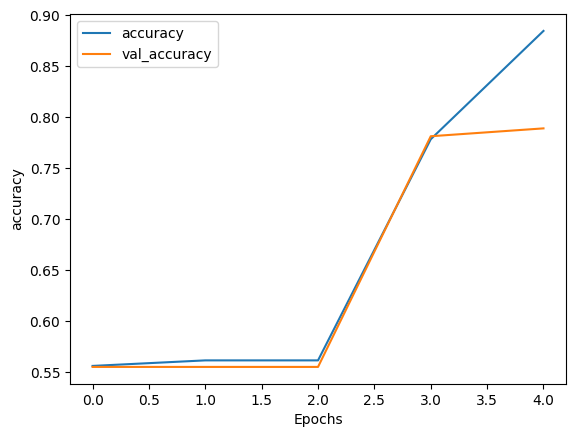

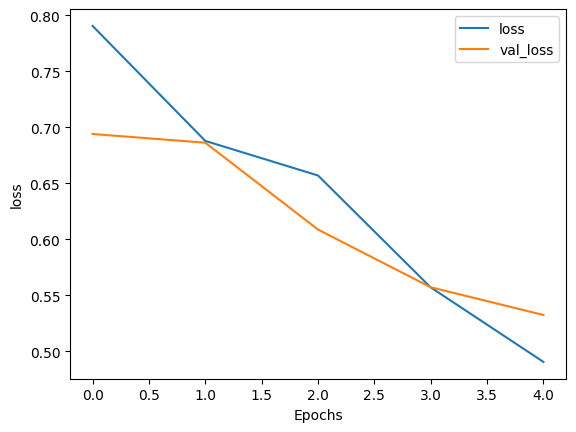

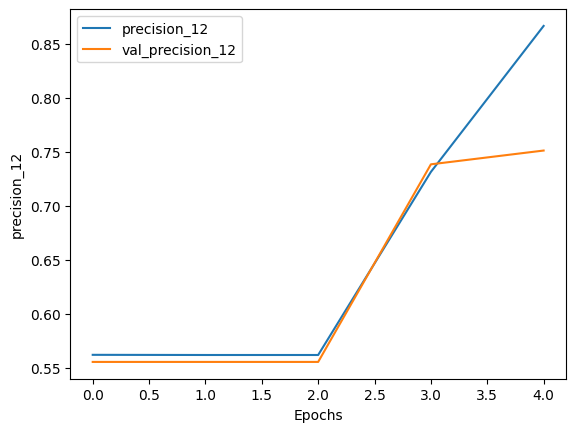

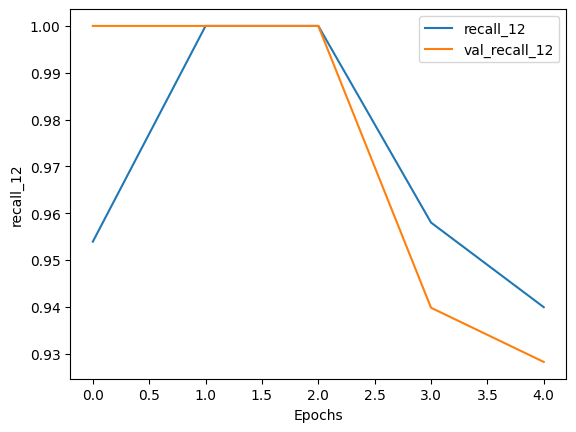

In [72]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
plot_graphs(history, "precision_12")
plot_graphs(history, "recall_12")

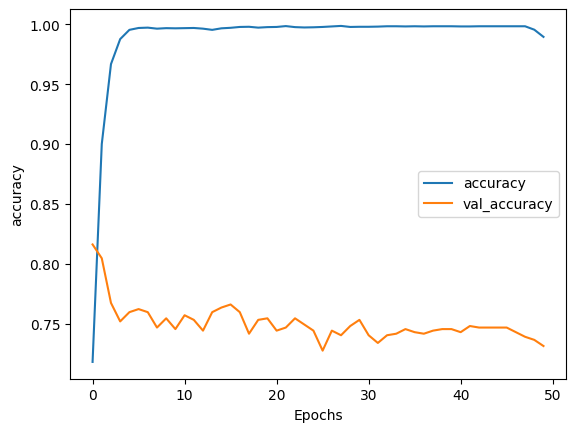

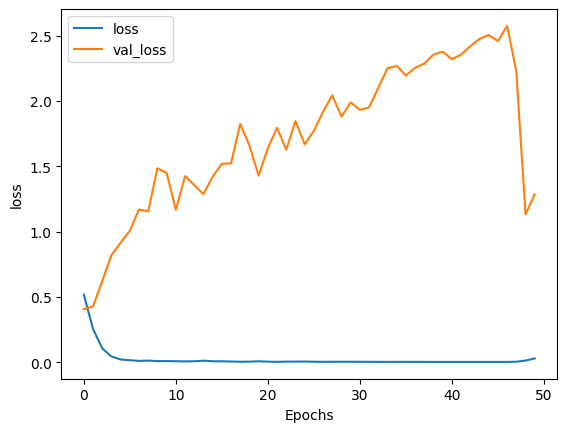

In [21]:
def plot_graphs(history_2, metric):
    plt.plot(history_2.history[metric])
    plt.plot(history_2.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history_2, "accuracy")
plot_graphs(history_2, "loss")

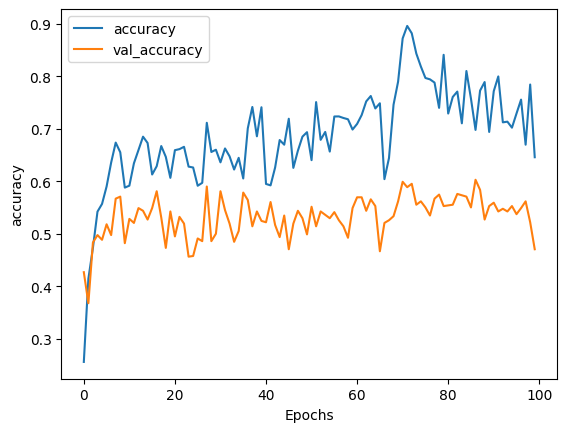

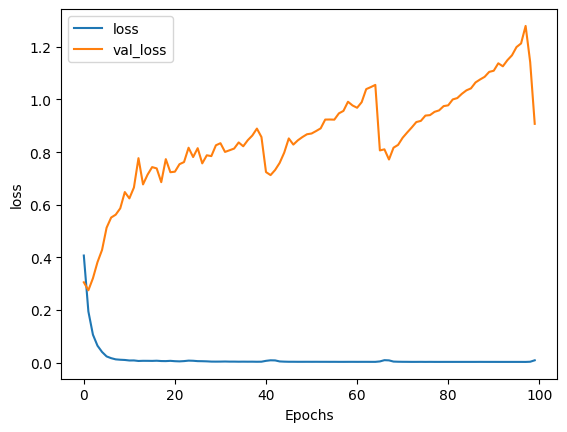

In [46]:
def plot_graphs(history_3, metric):
    plt.plot(history_3.history[metric])
    plt.plot(history_3.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history_3, "accuracy")
plot_graphs(history_3, "loss")

In [18]:
def plot_graphs(history_4, metric):
    plt.plot(history_4.history[metric])
    plt.plot(history_4.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history_4, "accuracy")
plot_graphs(history_4, "loss")

NameError: name 'history_4' is not defined

# Save The Model

In [73]:
model.save('toxic_comment_model_var_1_v3.h5')

# Make Prediction

In [108]:
# return 1 if toxic, 0 if not
predictions = model.predict(test_padded_seq)
predictions = [1 if x > 0.50 else 0 for x in predictions]

25/25 [==============================] - 0s 875us/step


In [111]:
np.array(test_labels, dtype=int) ^ np.array(predictions)
sum(np.array(test_labels, dtype=int) ^ np.array(predictions)) / len(test_labels)

0.21079691516709512

array([0, 1, 0, 1, 0])

In [388]:
i = 0
for test_sentence in test_sentences[:10]:
    print(i, predictions[i], test_sentence)
    i += 1
    print('\n')

0 [1] spanduk prof video orasi buku lainlain sngat heran rkyat tolol jls niat hizbut tahrir tega khilafah ganti negara satu republik indonesia kilah tega khilafah munafik apa khilafah


1 [1] gy sange gatel yh tetek memeky drnjng tdr dkmr smbil telnjng bugil mntf bunda gde lebat yh bulu jembut


2 [1] kali denger lagu enk in pngn praktekin gerakanya eh langsung afal lagu enk dngr mngkin lngsng afal lagu viral in


3 [1] astajim kasih penghargan sri antek asing yahudi tertawa disholatin bangkeknye marah


4 0 beda keluh langsung buly genk nya fr nya bagus juragan


5 0 agama diangep dilupain rusak papua sebentar pisah


6 [1] aneh anak emosi jiwa bangsat anjing kotor babi brengsek pakbis kesal shit kontol banteng sepong tok


7 0 soe production yups tuju bodoamat tga sblh bilang pencitran fakta smnjk wali kota sederhana


8 0 jakarta poling bijak publik p survei nasional juni juni pilih partai republik hasil takjub persen partai republik ubah konstitusi tetap kristen agama resmi nasiona

In [80]:
# make predictions on new sentences
def predict_toxicity(model, new_sentences, maxlen=MAXLEN, padding_type='post', trunc_type='post'):
    """
    Predicts the toxicity of new sentences
    
    Args:
        model (tf.keras Model): trained text classifier model
        new_sentences (list): new sentences to predict
        maxlen (int): length of the input sequences
    
    Returns:
        predictions (list): predicted toxicity of each sentence
    """
    
    ### START CODE HERE
    
    # preprocess the new sentences
    new_sequences = tokenizer.texts_to_sequences(new_sentences)
    new_padded = pad_sequences(new_sequences, maxlen=maxlen, padding=padding_type, truncating=trunc_type)
    
    # predict using the trained model
    predictions = model.predict(new_padded)
    
    ### END CODE HERE
    
    return predictions

In [105]:
new_sentences = ["Memek lo", 
                 "Lo ngentot aja", 
                 "Lo anjing", 
                 "Lo babi", 
                 "Lo kontol", 
                 "Lo tolol", 
                 "Lo goblok", 
                 "Lo idiot", 
                 "Lo bego", 
                 "Lo bodoh", 
                 "Lo dungu", 
                 "Lo tolol",
                 "memek anjing",
                 "mati aja lu",
                 "gua bunuh lu besok",
                 "anak haram mati aja lu",
                 "babi lu",
                 "minta gw lu",
                 "hari ini makan apa",
                 "kamu suka apa",
                 "besok kita ngapain ya",
                 "indomie seleraku",
                 "bosen hidup nih orang"]
pred = predict_toxicity(model, new_sentences)
pred = [1 if x > 0.50 else 0 for x in pred]
print(pred)

1/1 [==============================] - 0s 25ms/step
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]


# Load Model

In [438]:
model = tf.keras.models.load_model('toxic_comment_model_var_1_v2.h5')

# Save to Saved Model Format

In [5]:

# save to saved model format
tf.saved_model.save(model, "models/toxic_comment_model_var_1_savedmodel")

INFO:tensorflow:Assets written to: models/toxic_comment_model_var_1_savedmodel\assets


INFO:tensorflow:Assets written to: models/toxic_comment_model_var_1_savedmodel\assets


# Save Tokenizer

In [328]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [329]:
#loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Output processed text to csv

In [440]:
# output processed data sentences to csv
df = pd.DataFrame({'sentence': train_sentences, 'label': train_labels})
df.to_csv('dataset/processed_train_2.csv', index=False)

df = pd.DataFrame({'sentence': test_sentences, 'label': test_labels})
df.to_csv('dataset/processed_test_2.csv', index=False)
